In [25]:
# imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pathlib import Path
import tempfile

from PIL import Image, ImageCms, TiffTags
import matplotlib.pyplot as plt

from ipywidgets import IntProgress, Label, VBox
from IPython.display import display

In [3]:
# initial variables
root_dir_path = Path('/Users/dlisla/shared_with_docker/')
collection_dir_path = root_dir_path.joinpath('agrtfhs')

to_process_dir_path = collection_dir_path.joinpath('3.toQC')

tif_paths_list = sorted(to_process_dir_path.glob('**/*.tif'))
number_of_tifs = len(tif_paths_list)
print(f'number_of_tifs = {number_of_tifs}')

number_of_tifs = 3244


In [4]:
# which TIFF fields do we need to check for bit depth?
image = Image.open(tif_paths_list[0])
for tag in image.tag_v2:
    print(tag)
    print(TiffTags.lookup(tag))

256
TagInfo(value=256, name='ImageWidth', type=4, length=1, enum={})
257
TagInfo(value=257, name='ImageLength', type=4, length=1, enum={})
258
TagInfo(value=258, name='BitsPerSample', type=3, length=0, enum={})
259
TagInfo(value=259, name='Compression', type=3, length=1, enum={'Uncompressed': 1, 'CCITT 1d': 2, 'Group 3 Fax': 3, 'Group 4 Fax': 4, 'LZW': 5, 'JPEG': 6, 'PackBits': 32773})
262
TagInfo(value=262, name='PhotometricInterpretation', type=3, length=1, enum={'WhiteIsZero': 0, 'BlackIsZero': 1, 'RGB': 2, 'RGB Palette': 3, 'Transparency Mask': 4, 'CMYK': 5, 'YCbCr': 6, 'CieLAB': 8, 'CFA': 32803, 'LinearRaw': 32892})
273
TagInfo(value=273, name='StripOffsets', type=4, length=0, enum={})
339
TagInfo(value=339, name='SampleFormat', type=3, length=0, enum={})
277
TagInfo(value=277, name='SamplesPerPixel', type=3, length=1, enum={})
279
TagInfo(value=279, name='StripByteCounts', type=4, length=0, enum={})
282
TagInfo(value=282, name='XResolution', type=5, length=1, enum={})
283
TagInfo

In [5]:
# let's get data for our first image
tag_dict = {'BitsPerSample': 258,
            'Compression': 259,
            'SamplesPerPixel': 277,
           }
for key, value in tag_dict.items():
    print(f'{key} : {image.tag_v2[value]}')

BitsPerSample : (8, 8, 8)
Compression : 1
SamplesPerPixel : 3


In [6]:
# can use Image.getcolors() to identify if the image contains, color, grayscale, or only bitonal data
# if only 1-2 colors returned then bitonal (all black or all white = bitonal, too!)
# if 3-256 colors returned then grayscale
# if 257+ colors, it returns None and it has color data
color_list = image.getcolors()
if color_list is None:
    number_of_colors = 'Over 256 colors'
else:
    number_of_colors = len(color_list)
print(f'Number of colors in the image: {number_of_colors}')

Number of colors in the image: Over 256 colors


In [7]:
# working functions
bit_depth_lookup_dict = {24: 'rgb',
                         8: 'gray',
                         1: 'bitonal',
                        }
bits_per_sample_lookup_dict = {(8, 8, 8): 24,
                               (8,): 8,
                               (1,): 1,
                              }
compression_lookup_dict = {1: 'uncompressed',
                           4: 'group4',
                           5: 'LZW',
                           6: 'JPEG',
                          }

def get_bit_depth_from_colors(image):
    color_list = image.getcolors()
    if color_list is None:  # image is over 256 colors
        bit_depth = 24
    else:
        number_of_colors = len(color_list)
        if number_of_colors > 2:
            bit_depth = 8
        elif number_of_colors > 0:
            bit_depth = 1
        else:
            bit_depth = None
    return bit_depth

def get_bit_depth_from_metadata(image):
    BitsPerSample = image.tag_v2[258]  ## tag 258 is the BitsPerSample tag
    bit_depth = bits_per_sample_lookup_dict[BitsPerSample]
    if isinstance(bit_depth, int):
        return bit_depth
    else:
        raise TypeError(f'"{bit_depth}" is not an int')

def get_compression(image):
    compression = image.tag_v2[259]
    compression = compression_lookup_dict[compression]
    return compression

In [8]:
print(f'{image_path.parts[-2]}/{image_path.name}')

NameError: name 'image_path' is not defined

In [9]:
# progress bar
progress_label = Label('Process *.tif')
progress_bar = IntProgress(min=0, max=number_of_tifs)
progress_widget = VBox([progress_label, progress_bar])
display(progress_widget)

# NOTE: writing this as a for-loop, but need to come back and
# refactor into OOP after getting logic and processes down
rgb_paths_list = []
gray_paths_list = []
bitonal_paths_list = []
bitdepth_doesnt_match_paths_list = []

for index, image_path in enumerate(tif_paths_list):
    label = f'Processing {index} of {number_of_tifs}\n {image_path.parts[-2]}/{image_path.name}'
    progress_label.value = label
    image = Image.open(image_path)
    bit_depth_from_colors = get_bit_depth_from_colors(image)
    bit_depth_from_metadata = get_bit_depth_from_metadata(image)
    if bit_depth_from_colors != bit_depth_from_metadata:
        print(f'{image_path.name}: colors and metadata do not match')
        bitdepth_doesnt_match_paths_list.append(image_path)
    else:
        bit_depth = bit_depth_from_colors
    if bit_depth == 24:
        rgb_paths_list.append(image_path)
    elif bit_depth == 8:
        gray_paths_list.append(image_path)
    elif bit_depth == 1:
        bitonal_paths_list.append(image_path)
    else:
        raise ValueError(f'{bit_depth} is not 1, 8, or 24')
    
    if bit_depth > 1:
        compression = get_compression(image)
        if compression == 'LZW':  # re-save image uncompressed
            image.save(image_path, tiffinfo=image.tag, compression=None, dpi=image.info['dpi'])
    
    # increment progress_bar
    progress_bar.value = index + 1
else:  # no break
    label = f'Processing complete'
    progress_label.value = label

    #print(f'{image_path.name} --> {bit_depth_lookup_dict[bit_depth_from_colors]}')

000006.tif: colors and metadata do not match
000011.tif: colors and metadata do not match
000010.tif: colors and metadata do not match
000006.tif: colors and metadata do not match
000012.tif: colors and metadata do not match
000007.tif: colors and metadata do not match
000020.tif: colors and metadata do not match
000021.tif: colors and metadata do not match
000021.tif: colors and metadata do not match
000004.tif: colors and metadata do not match
000006.tif: colors and metadata do not match
000008.tif: colors and metadata do not match
000009.tif: colors and metadata do not match
000010.tif: colors and metadata do not match
000011.tif: colors and metadata do not match
000012.tif: colors and metadata do not match
000013.tif: colors and metadata do not match
000014.tif: colors and metadata do not match
000016.tif: colors and metadata do not match
000017.tif: colors and metadata do not match
000019.tif: colors and metadata do not match
000020.tif: colors and metadata do not match
000021.tif

In [10]:
len(bitdepth_doesnt_match_paths_list)

77

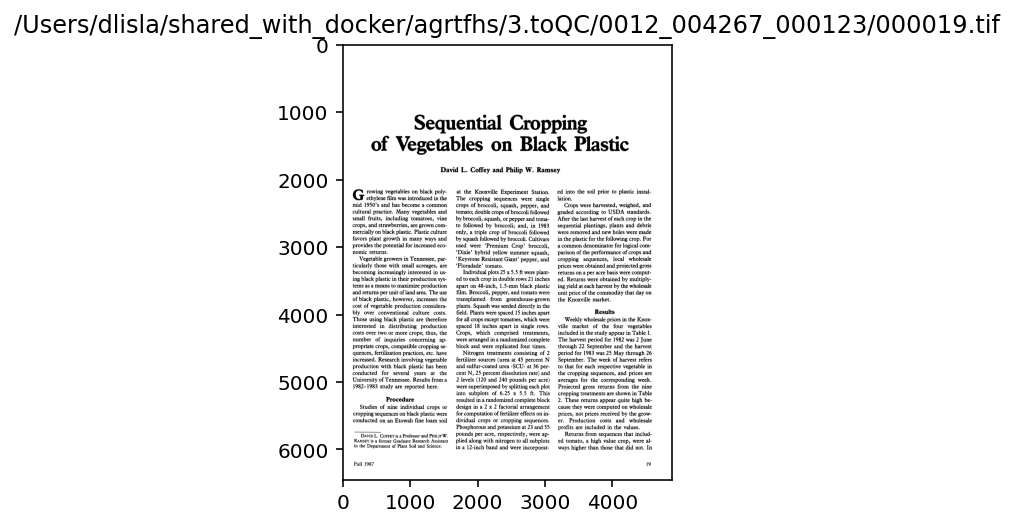

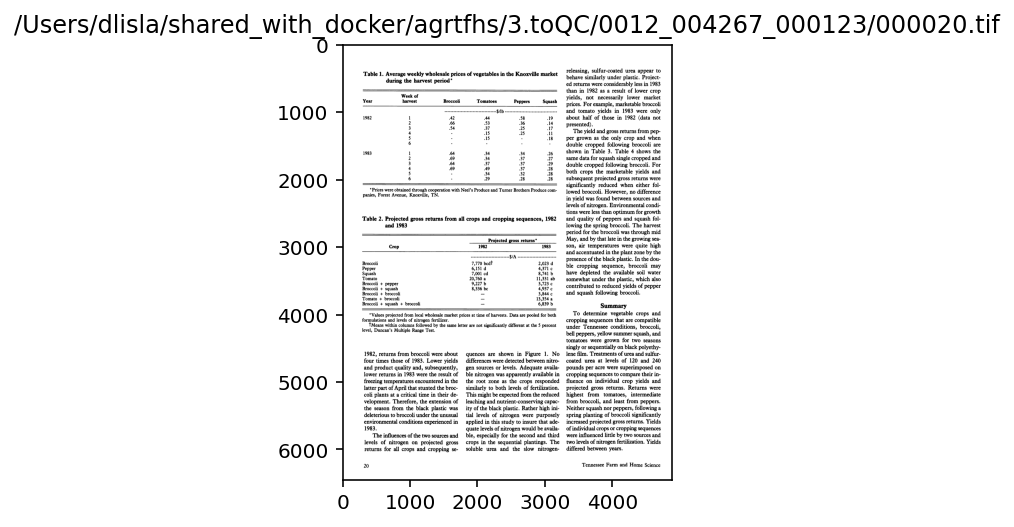

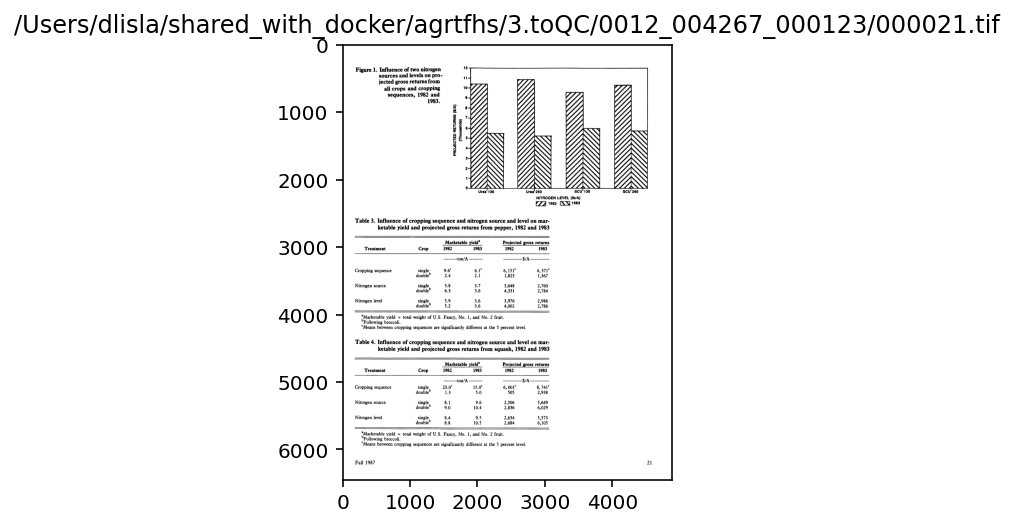

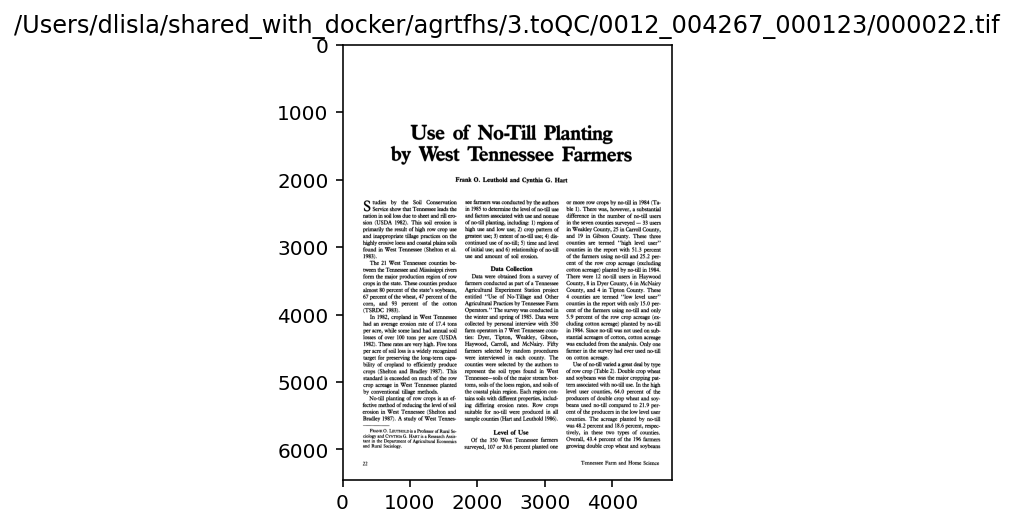

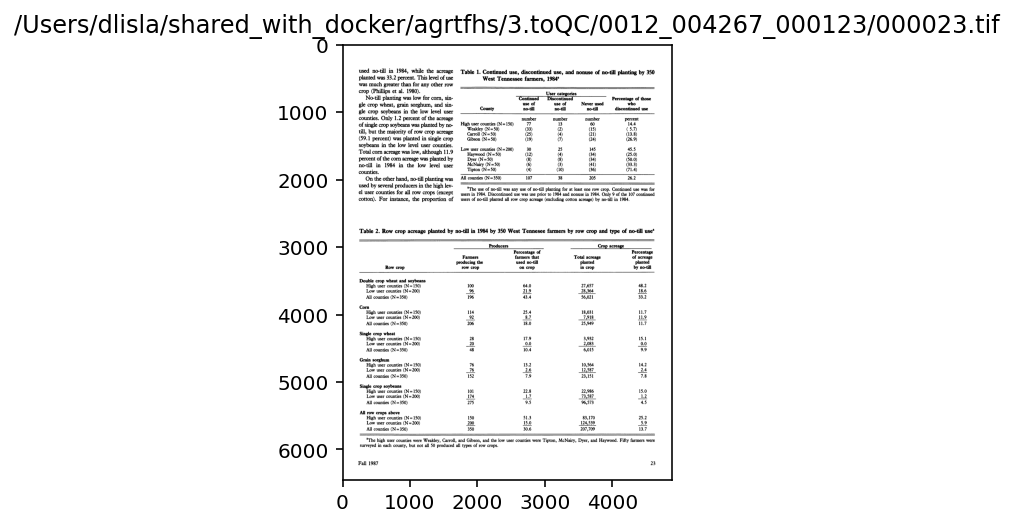

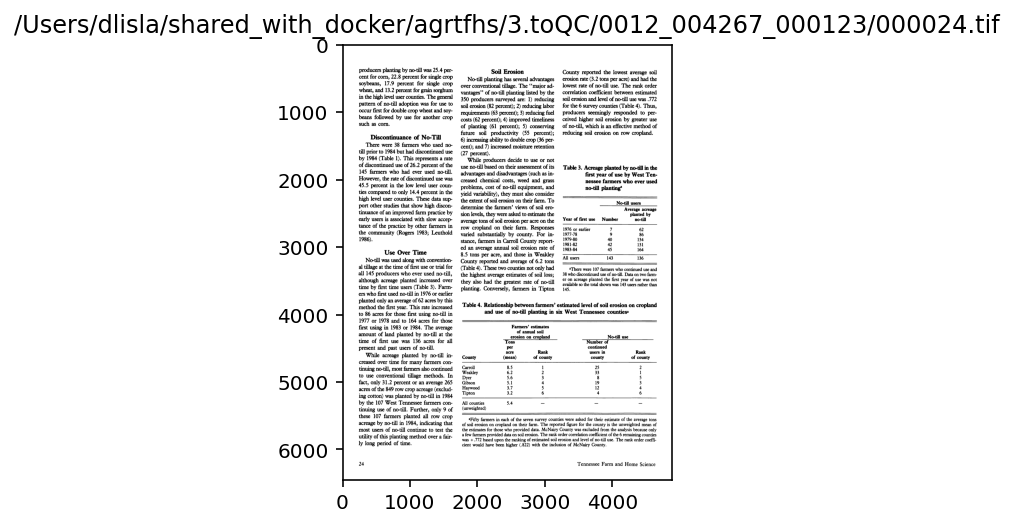

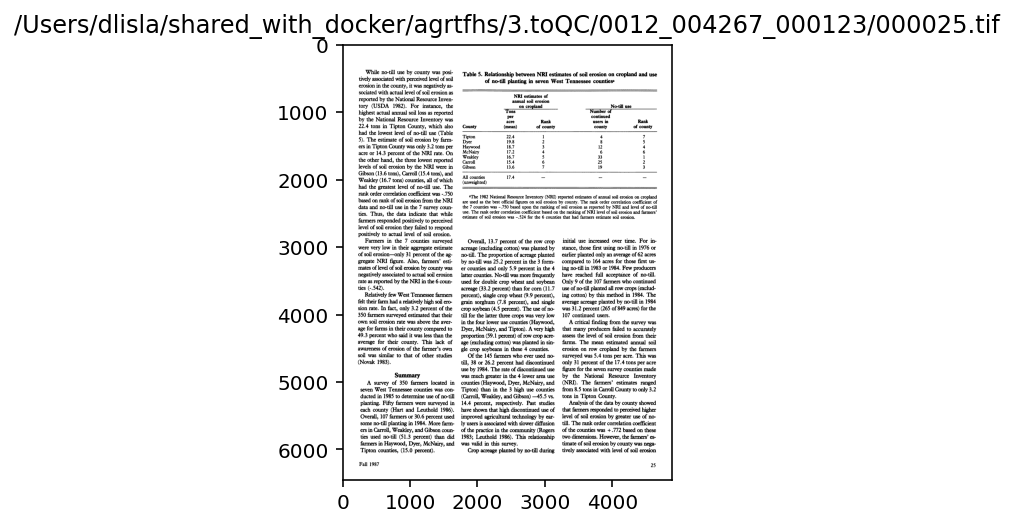

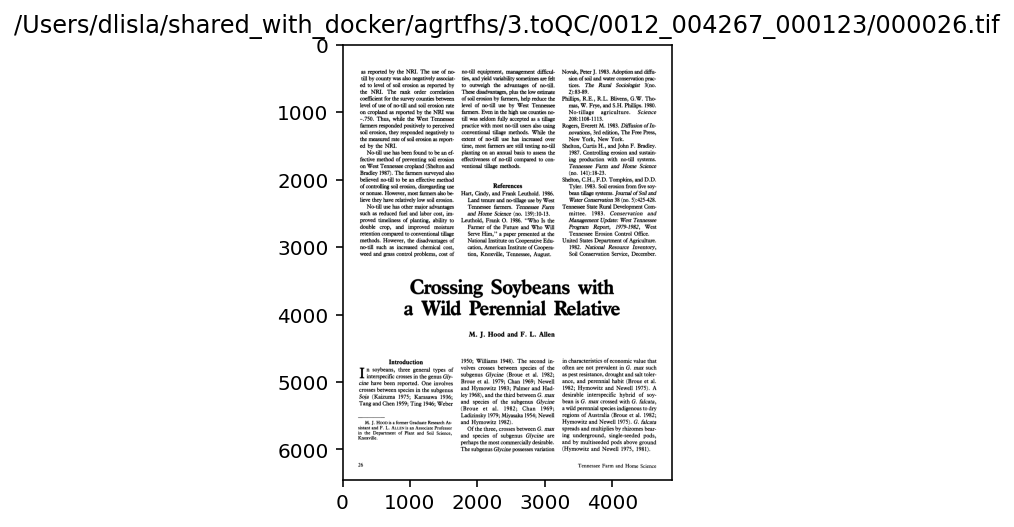

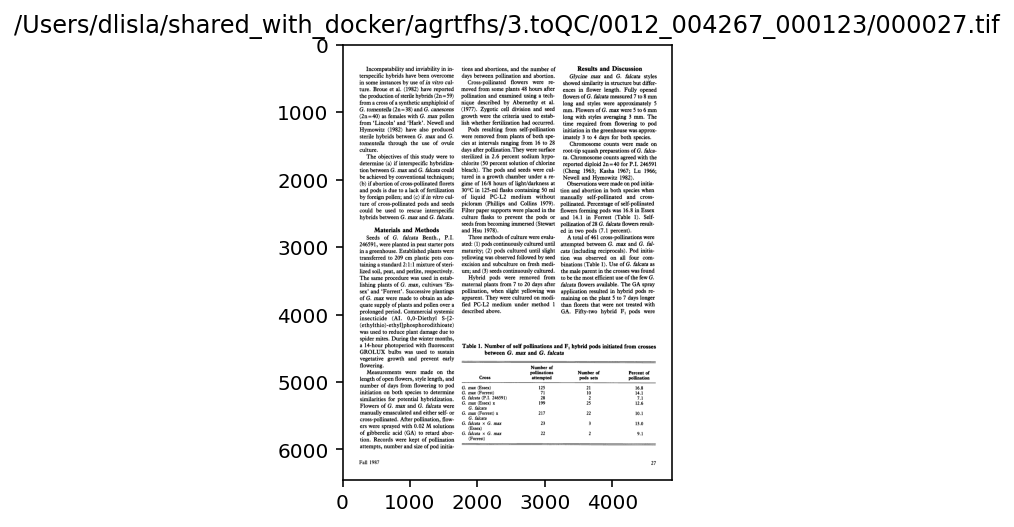

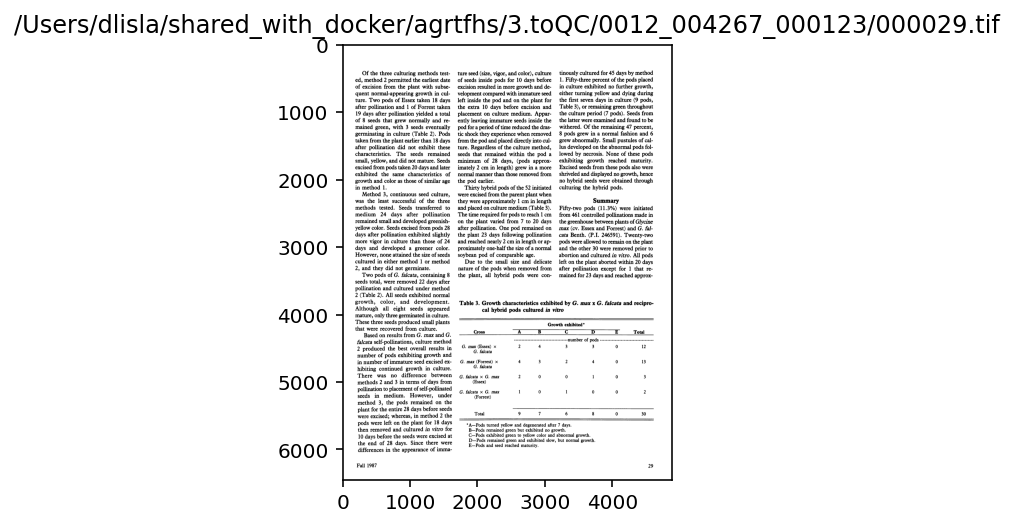

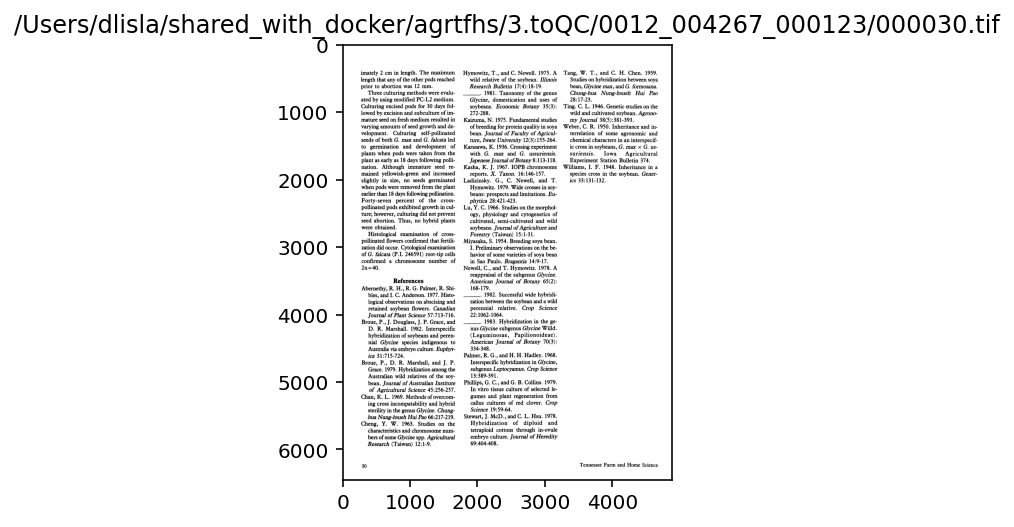

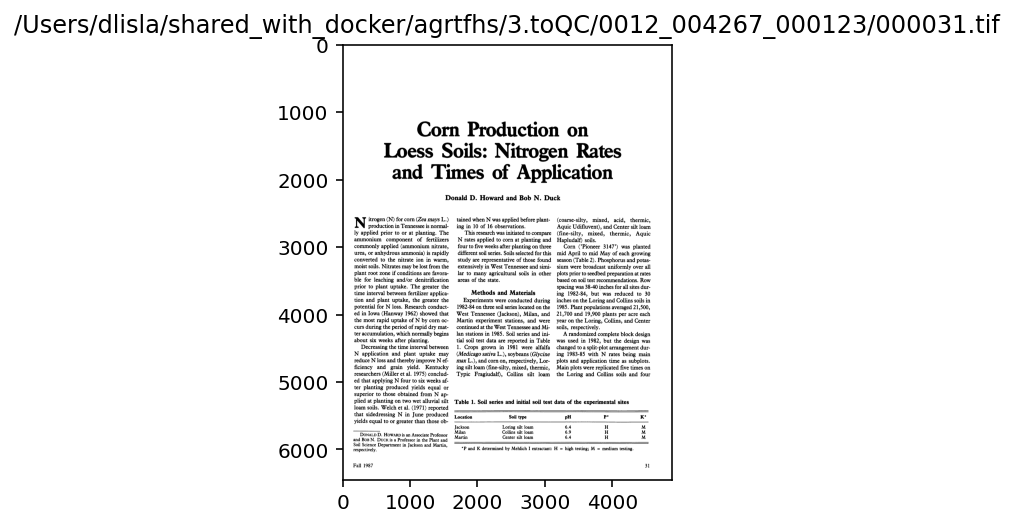

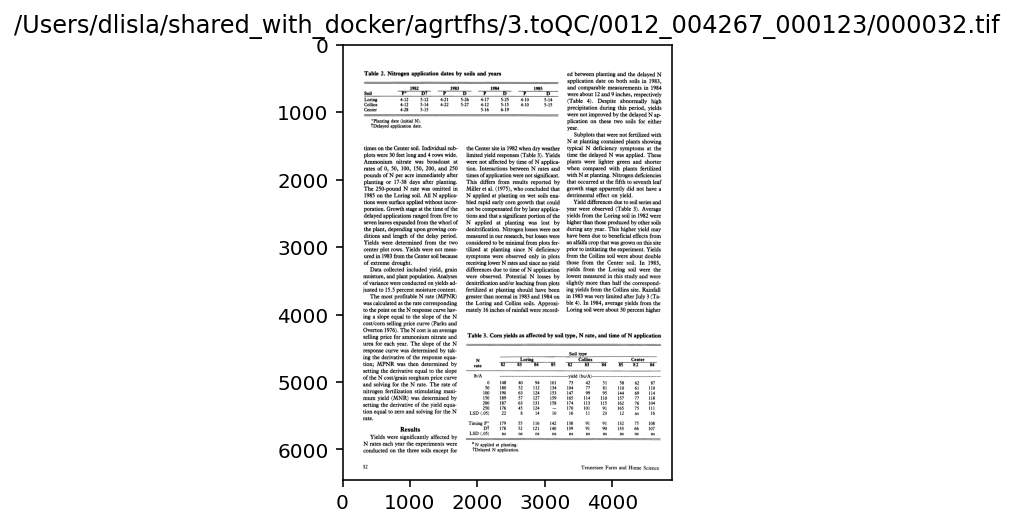

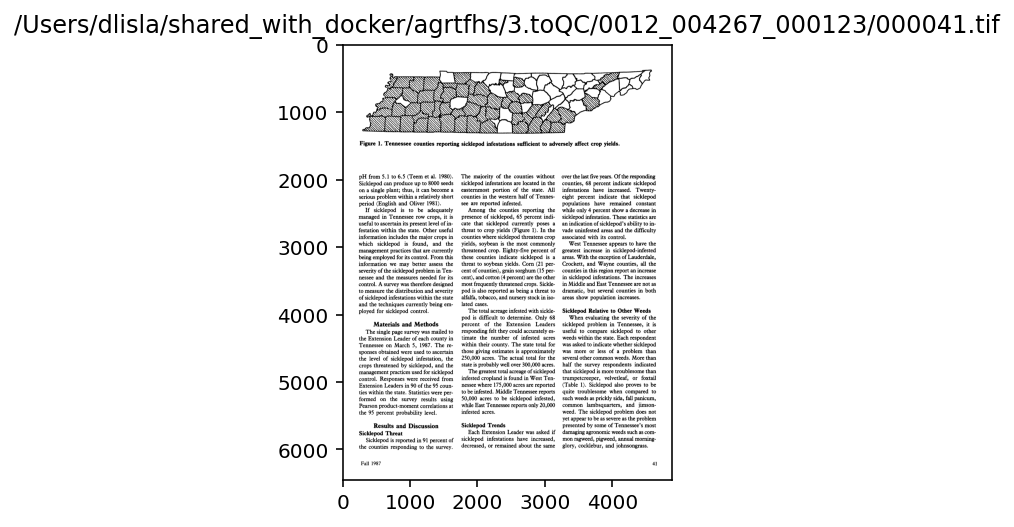

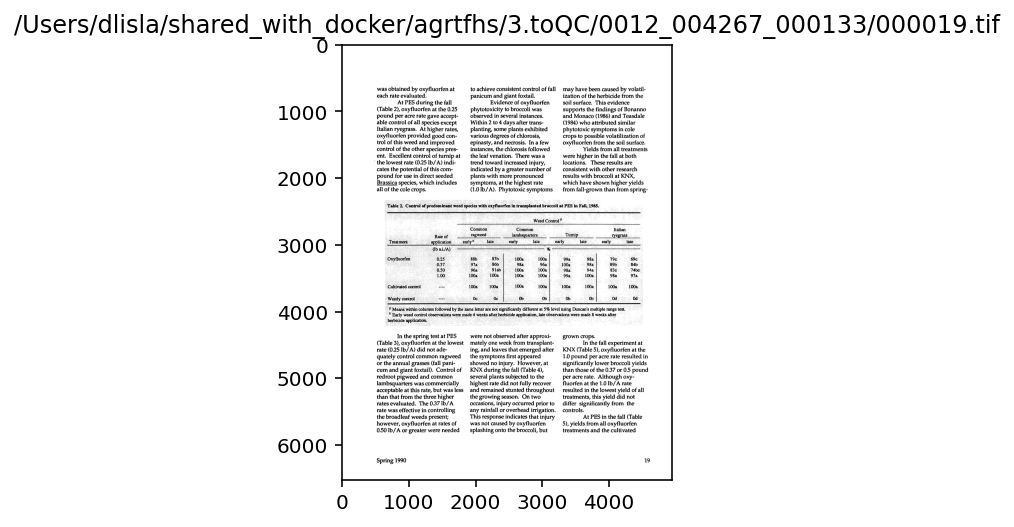

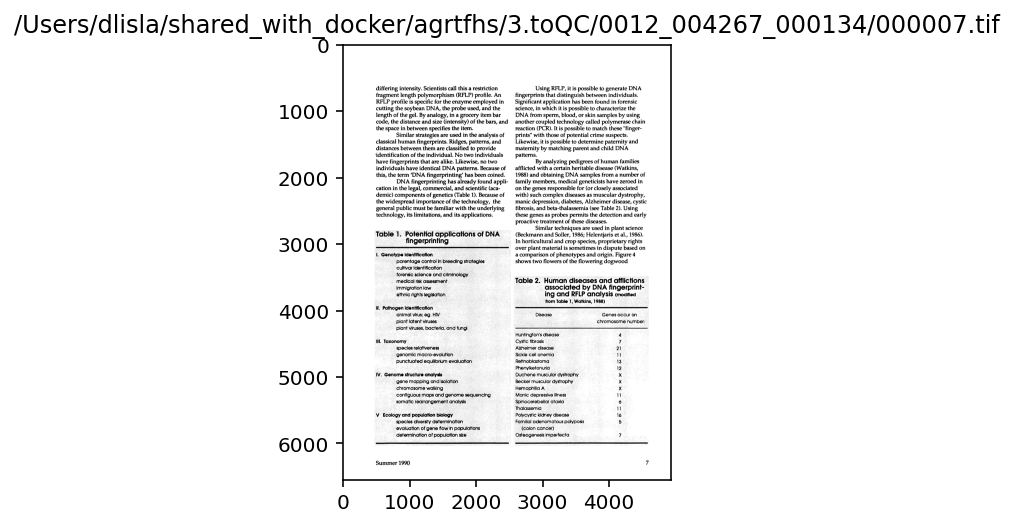

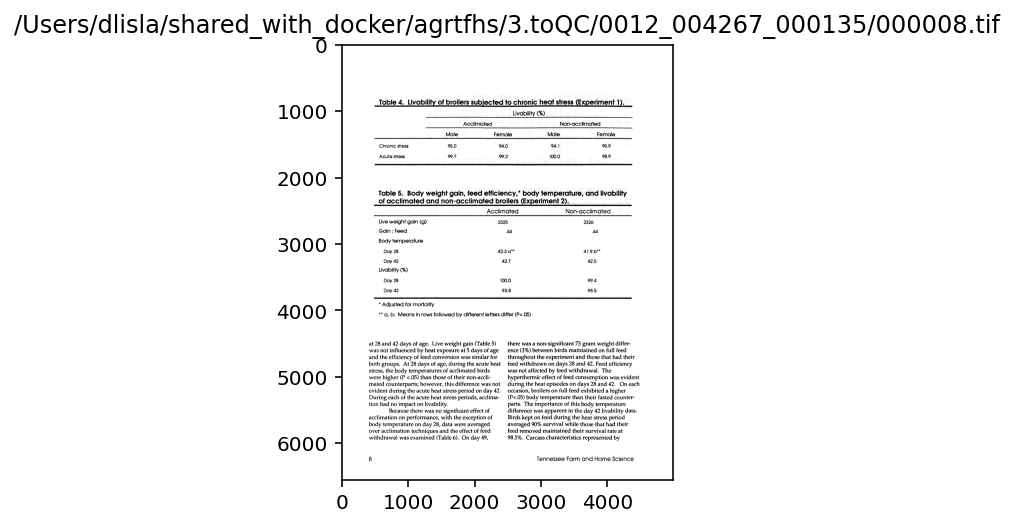

In [37]:
for image_path in bitdepth_doesnt_match_paths_list[60:]:
    image = Image.open(image_path)
    # create a new MatPlotLib figure so we can plot each image
    plt.figure()
    plt.title(image_path)
        
    # show image
    plt.imshow(image, cmap='gray')

In [ ]:
# what do we need to check and in what order?
# if continuous tone we should verify that it's not bitonal by getting image as 
check_if_color_path_list = []
grayscale_path_list = []
if image.tag_v2[258] == '(8, 8, 8)': # image is color
    check_if_color_path_list.append(tif_path)
elif image.tag_v2[258] == 8:
    check_if_grayscale

In [ ]:
# open in Preview
image.show()